# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

documents = [
    'a dog eats meat',
    'a dog hunts cat'
]

vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", use_idf=True, smooth_idf=False)
X = vectorizer.fit_transform(documents)
print(vectorizer.get_feature_names_out())
# print(vectorizer.vocabulary_)
print(vectorizer.idf_)
X.toarray()

['a' 'cat' 'dog' 'eats' 'hunts' 'meat']
[1.         1.69314718 1.         1.69314718 1.69314718 1.69314718]


array([[0.35959372, 0.        , 0.35959372, 0.6088451 , 0.        ,
        0.6088451 ],
       [0.35959372, 0.6088451 , 0.35959372, 0.        , 0.6088451 ,
        0.        ]])

### Установка зависимостей

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [2]:
import PIL
print(PIL.__version__)

9.4.0


In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

ModuleNotFoundError: No module named 'google'

In [7]:
# !unzip -q /content/gdrive/MyDrive/journey-springfield.zip

replace characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
!ls train

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Dec  3 11:00:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.86       Driver Version: 526.86       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P0    16W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

False

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [9]:
!pip install scikit-image

     ---------------------------------------- 24.5/24.5 MB 4.1 MB/s eta 0:00:00
     -------------------------------------- 313.3/313.3 kB 3.9 MB/s eta 0:00:00
     -------------------------------------- 222.9/222.9 kB 4.5 MB/s eta 0:00:00


In [10]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision.transforms import v2
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [13]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device(

device(type='cpu')

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [13]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, transform=None):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        if transform is None:
          transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
        self.transform = transform

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = self.transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [14]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [15]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [16]:
TRAIN_DIR

PosixPath('train')

In [17]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [18]:
train_val_files[0]

PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg')

In [19]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [20]:
train_val_labels[0]

'abraham_grampa_simpson'

In [21]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [22]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

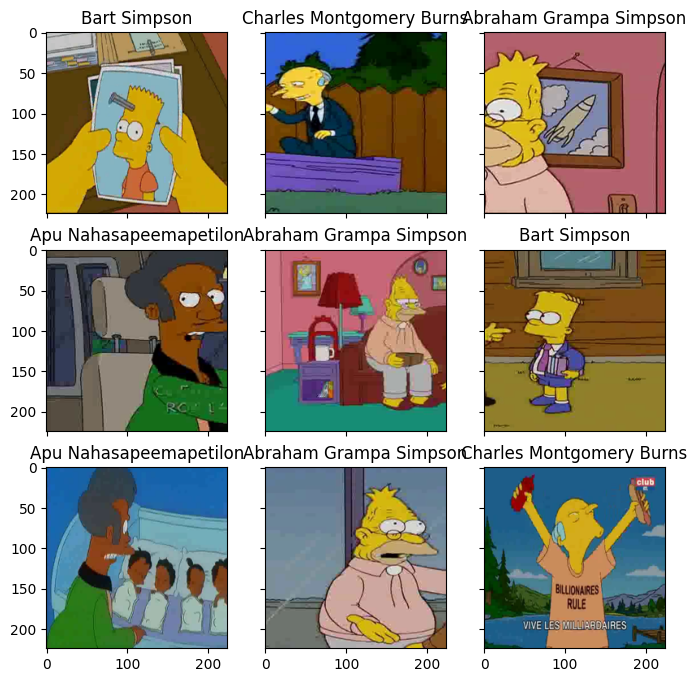

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [24]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.LazyLinear(n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [25]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler=None):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    if scheduler is not None:
      scheduler.step()

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [26]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [27]:
def train(train_dataset, val_dataset, model, epochs, batch_size, criterion, optimizer, scheduler):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # opt = torch.optim.Adam(model.parameters())
        # criterion = nn.CrossEntropyLoss()
        # scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.75)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, scheduler)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [28]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [29]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): LazyLinear(in_features=0, out_fe

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Запустим обучение сети.

In [30]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(simple_cnn.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5)
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=11, batch_size=64,
                criterion=criterion, optimizer=optimizer, scheduler=scheduler)

epoch:   0%|          | 0/11 [00:00<?, ?it/s]

loss 2.626712667432528


epoch:   9%|▉         | 1/11 [10:10<1:41:47, 610.71s/it]


Epoch 001 train_loss: 2.6267     val_loss 2.0439 train_acc 0.2698 val_acc 0.4459
loss 1.591873194436464


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

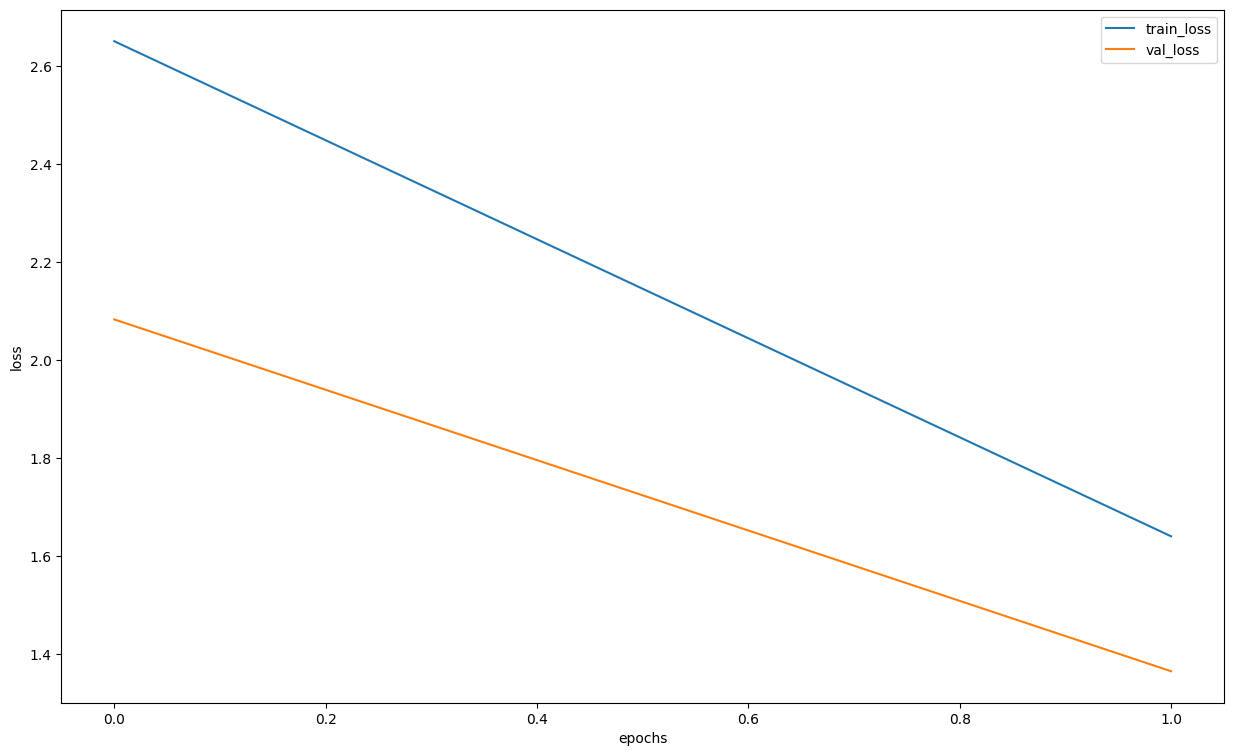

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
np.unique(actual_labels, return_counts=True)

(array([0, 2, 4, 6]), array([ 3,  2, 12,  3]))

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
# micro-F1 counts TP, FP, TN, TP for each class and averages them out for precision and recall (takes into account the class imbalance)
# micro-F1 counts precision and recall for each class and averages them out for calculating F1 (does not take into account the class imbalance)

from sklearn.metrics import f1_score, confusion_matrix
f1_macro = f1_score(actual_labels, y_pred, average='macro')
f1_micro = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка (macro):", f1_macro)
print("F1-оценка (micro):", f1_micro)
print(confusion_matrix(actual_labels, y_pred))

F1-оценка (macro): 0.0
F1-оценка (micro): 0.0
[[0 0 0 2 0 1 0 0]
 [0 0 0 0 0 0 2 0]
 [0 0 0 0 1 1 5 5]
 [0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


In [ ]:
actual_labels, y_pred

([4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 2, 0, 6, 2, 0, 6, 4, 4, 4, 6],
 array([32, 11, 28,  6, 32, 28, 32, 28, 32, 32, 28, 12, 28, 28,  6, 28, 28,
        28, 12, 28]))

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

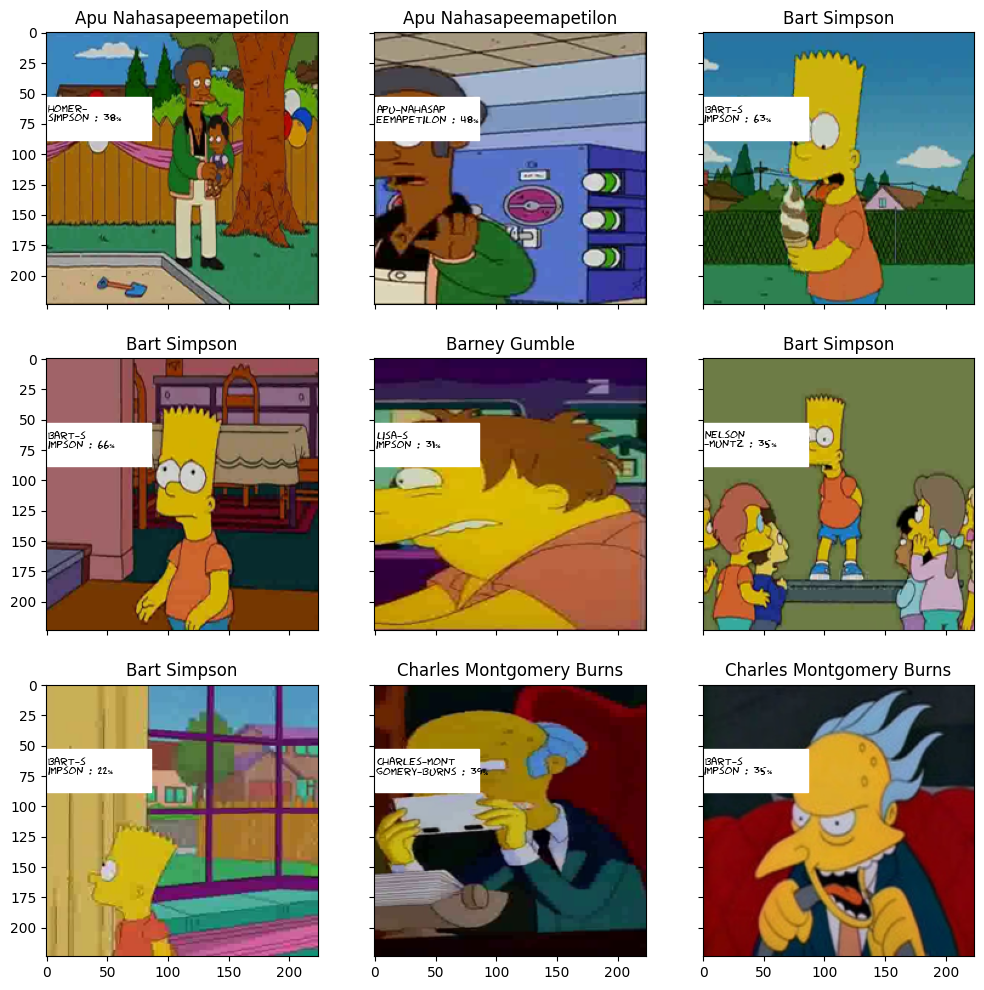

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

Посмотрим на изображения, которые были распознаны неправильно:

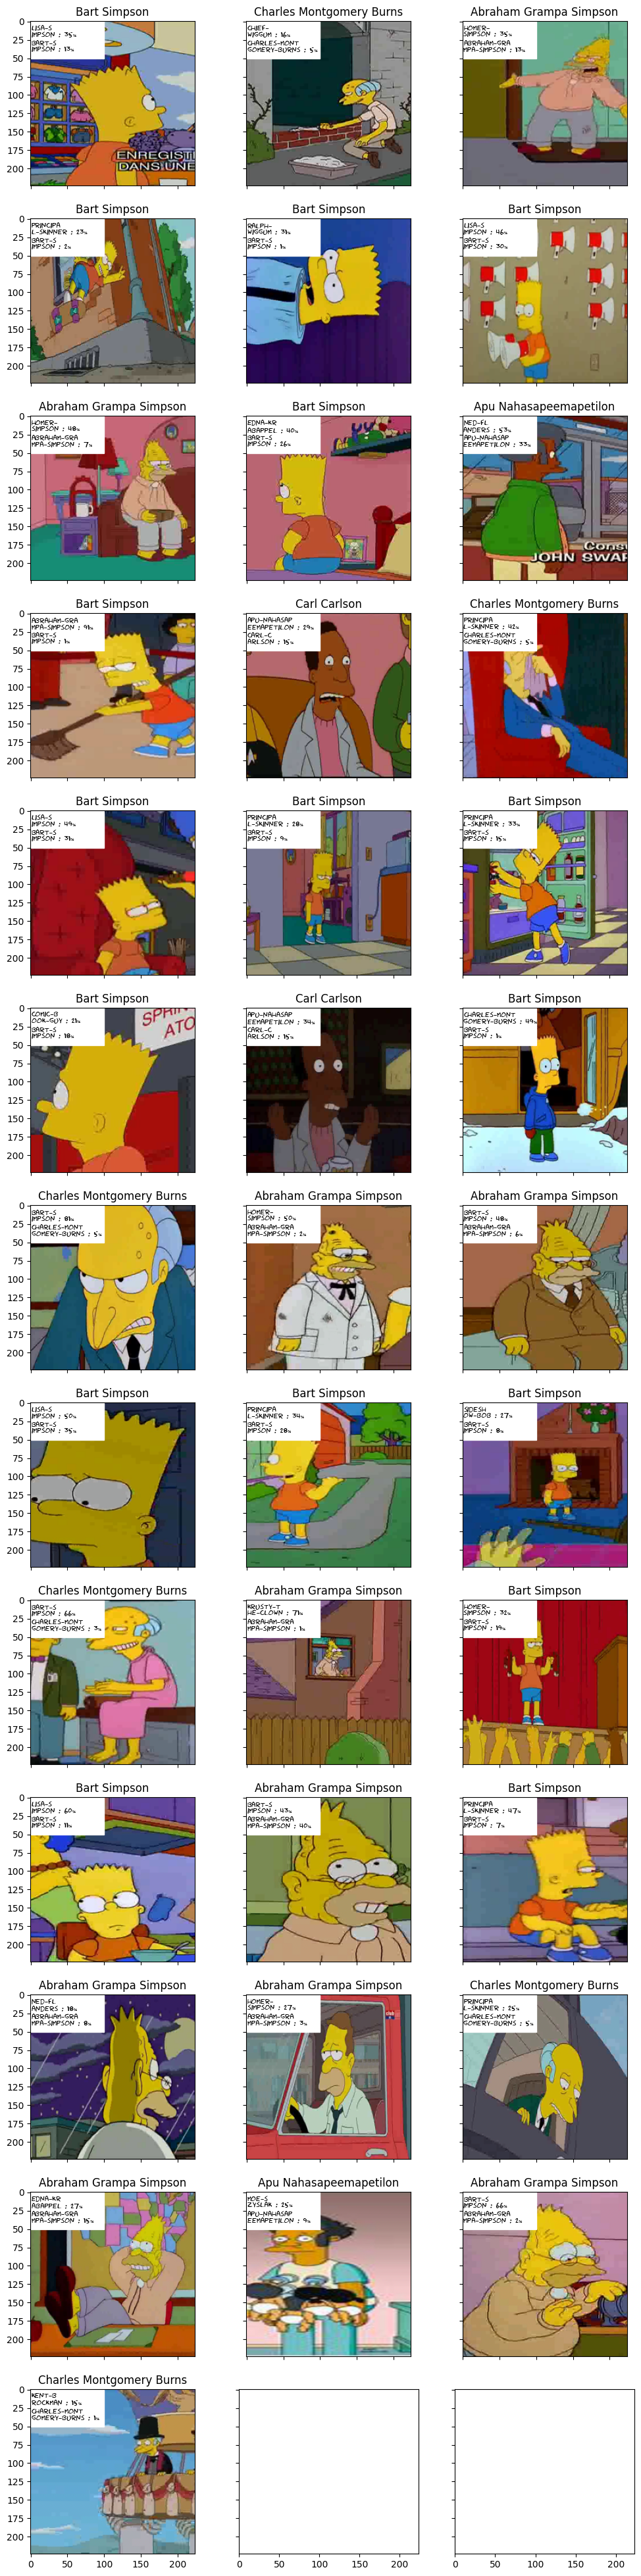

In [ ]:
from torch.utils.data import Subset, DataLoader

IMGS_COUNT = 100
rand_inds = np.random.randint(0, 1000, IMGS_COUNT)
subset = Subset(val_dataset, rand_inds)
im_vals = torch.stack([subset[i][0].unsqueeze(0) for i in range(IMGS_COUNT)])
labels = torch.tensor([subset[i][1] for i in range(IMGS_COUNT)])
prob_pred = torch.tensor(predict(simple_cnn, im_vals))
classes_pred = torch.argmax(prob_pred, -1)
wrong_inds = (~(classes_pred == labels)).nonzero().flatten()
im_vals, labels, prob_pred = Subset(im_vals, wrong_inds), Subset(labels, wrong_inds), Subset(prob_pred, wrong_inds)

fig, ax = plt.subplots(nrows=len(wrong_inds) // 3 + 1, ncols=3,figsize=(12, 12 // 3 * len(wrong_inds) // 3 + 1), \
                        sharey=True, sharex=True)
for label, im_val, fig_x in zip(labels, im_vals, ax.flatten()):
    im_val = torch.squeeze(im_val)
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 0),100, 50,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    true_proba = prob_pred[0, label]*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    true_label = label_encoder.classes_[label]
    true_label = true_label[:len(true_label)//2] + '\n' + true_label[len(true_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)
    true_text = "{} : {:.0f}%".format(true_label, true_proba)

    fig_x.text(1, 5, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')
    fig_x.text(1, 25, true_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Можно предположить, что неверное распознавание происходит в случаях, когда объект находится не в центре картинки, когда кроме искомого объекта на изображении присутствуют другие персонажи

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [ ]:
import pandas as pd
# my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

NameError: ignored

In [ ]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"t4rwerka","key":"91094708e6bb5e26f545f52a71fdce13"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets list

ref                                                            title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                                DAIGT V2 Train Dataset                              29MB  2023-11-16 01:38:36            993        110  1.0              
muhammadbinimran/housing-price-prediction-data                 Housing Price Prediction Data                      763KB  2023-11-21 17:56:32           3628         75  1.0              
carlmcbrideellis/llm-7-prompt-training-dataset                 LLM: 7 prompt training dataset                      41MB  2023-11-15 07:32:56           1375        105  1.0              
thedrcat/daigt-proper-train-dataset                            DAIGT P

In [ ]:
!kaggle competitions submit journey-springfield -f simple_cnn_baseline.csv -m "Yeah! I submit my file through the Google Colab!"

100% 25.6k/25.6k [00:01<00:00, 21.5kB/s]
Successfully submitted to Journey to Springfield

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


In [ ]:
aug_train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(200, antialias=True),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

aug_val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(200),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_data = SimpsonsDataset(train_files, 'train', aug_train_transform)
val_data = SimpsonsDataset(val_files, 'val', aug_train_transform)

In [ ]:
val_data[100][0].shape

torch.Size([3, 200, 200])

In [ ]:
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
aug_history = train(train_data, val_data, model=simple_cnn, epochs=10, batch_size=64)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.904468785532645


epoch:  10%|█         | 1/10 [02:22<21:23, 142.64s/it]


Epoch 001 train_loss: 2.9045     val_loss 2.5852 train_acc 0.1800 val_acc 0.2902
loss 2.4321909467007172


epoch:  20%|██        | 2/10 [04:44<18:55, 141.97s/it]


Epoch 002 train_loss: 2.4322     val_loss 2.2718 train_acc 0.3352 val_acc 0.3806


epoch:  20%|██        | 2/10 [05:08<20:33, 154.19s/it]


KeyboardInterrupt: ignored

In [ ]:
aug_loss, aug_acc, aug_val_loss, aug_val_acc = zip(*aug_history)
aug_val_acc = [acc.item() for acc in aug_val_acc]

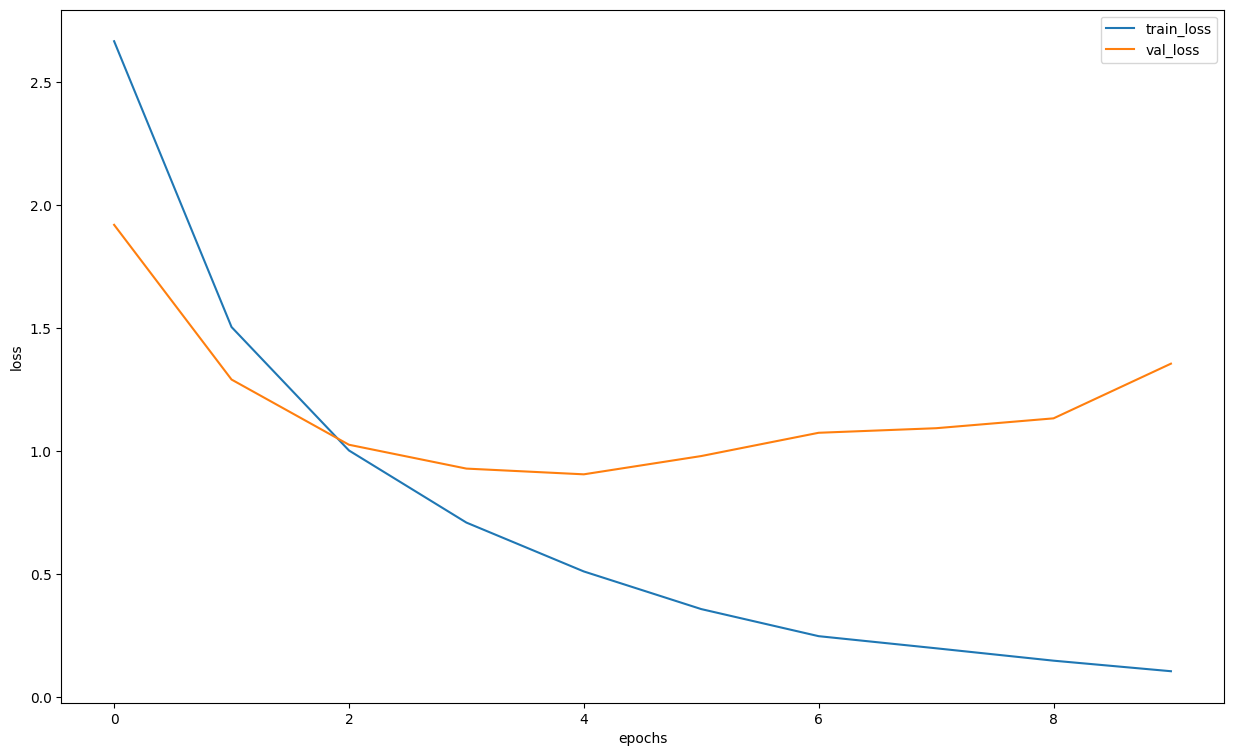

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(aug_loss, label="train_loss")
plt.plot(aug_val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(aug_acc, label="train_accuracy")
plt.plot(aug_val_acc, label="val_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()
plt.show()

In [ ]:
class SimpleCnnV2(nn.Module):
  def __init__(self, n_classes):
    super(SimpleCnnV2, self).__init__()
    self.conv1 = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.BatchNorm2d(8),
    )
    self.conv2 = nn.Sequential(
      nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.BatchNorm2d(16),
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(32),
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(64),
    )
    self.conv5 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(96),
    )

    self.fc1 = nn.Sequential(
        nn.LazyLinear(4096),
        nn.BatchNorm1d(4096),
    )
    self.fc2 = nn.Linear(4096, n_classes)


  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)

    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    logits = self.fc2(x)
    return logits

In [ ]:
aug_val_acc

[0.48910966755827284,
 0.6448223156285824,
 0.7325181505540695,
 0.7602216278181123,
 0.7825754680932365,
 0.7676729079098203,
 0.7810470003821169,
 0.7863966373710355,
 0.7904088651127245,
 0.7905999235766145]

In [ ]:
model_v2 = SimpleCnnV2(n_classes).to(DEVICE)
history_v2 = train(train_data, val_data, model=model_v2, epochs=5, batch_size=64)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 3.0992463837232442


epoch:  20%|██        | 1/5 [02:24<09:38, 144.62s/it]


Epoch 001 train_loss: 3.0992     val_loss 2.5856 train_acc 0.3040 val_acc 0.3804
loss 2.139782329290276


epoch:  40%|████      | 2/5 [04:48<07:12, 144.04s/it]


Epoch 002 train_loss: 2.1398     val_loss 2.0371 train_acc 0.4584 val_acc 0.4820
loss 1.7542640140644494


epoch:  60%|██████    | 3/5 [07:09<04:45, 142.62s/it]


Epoch 003 train_loss: 1.7543     val_loss 1.6131 train_acc 0.5317 val_acc 0.5711
loss 1.4970943194694963


epoch:  80%|████████  | 4/5 [09:31<02:22, 142.41s/it]


Epoch 004 train_loss: 1.4971     val_loss 1.4612 train_acc 0.5925 val_acc 0.5984
loss 1.4074364355456503


epoch: 100%|██████████| 5/5 [11:53<00:00, 142.71s/it]


Epoch 005 train_loss: 1.4074     val_loss 1.3139 train_acc 0.6198 val_acc 0.6498


In [ ]:
loss_v2, acc_v2, val_loss_v2, val_acc_v2 = zip(*history_v2)
val_acc_v2 = [acc.item() for acc in val_acc_v2]

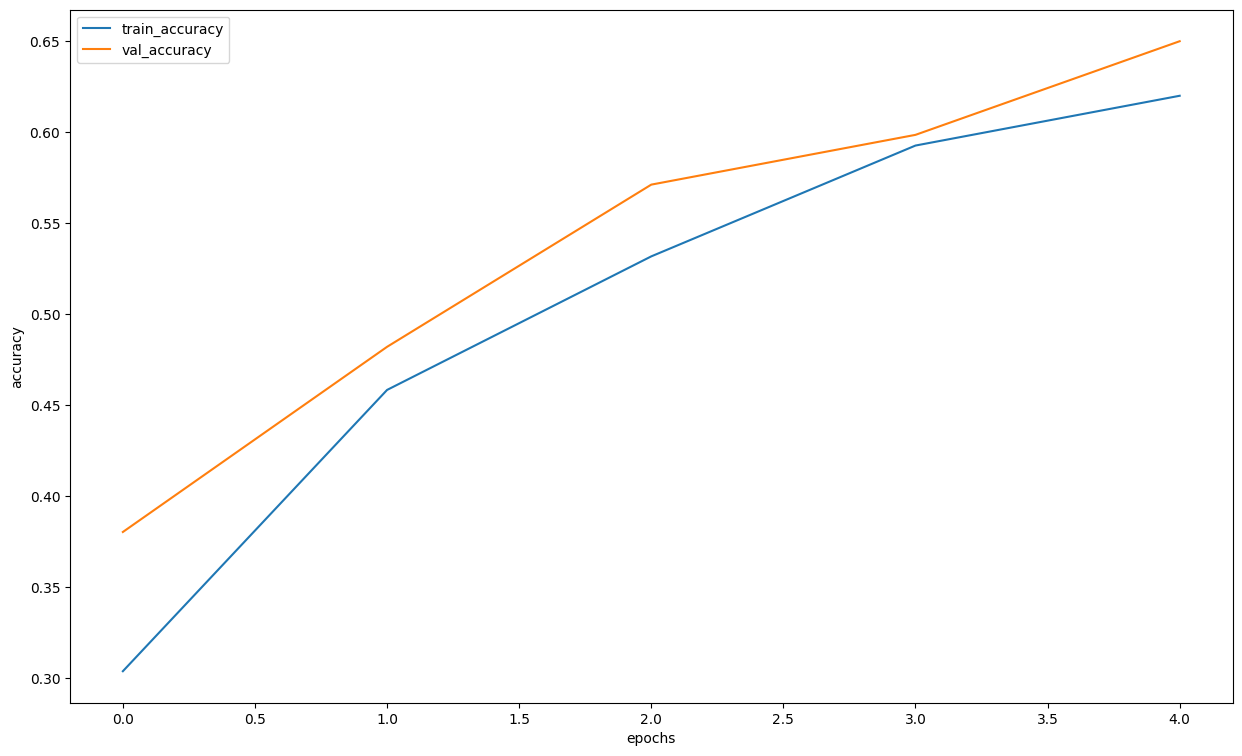

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc_v2, label="train_accuracy")
plt.plot(val_acc_v2, label="val_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [ ]:
class SimpleCnnV3(nn.Module):
  def __init__(self, n_classes):
    super(SimpleCnnV3, self).__init__()
    self.conv1 = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.BatchNorm2d(8),
    )
    self.conv2 = nn.Sequential(
      nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Dropout(0.1),
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(32),
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout(0.1),
    )

    self.fc1 = nn.Sequential(
        nn.LazyLinear(4096),
        nn.BatchNorm1d(4096),
        nn.Dropout(0.5),
    )
    self.fc2 = nn.Sequential(
        nn.Linear(4096, 256),
        nn.BatchNorm1d(256),
    )
    self.fc3 = nn.Linear(256, n_classes)


  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)

    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.fc2(x)
    logits = self.fc3(x)
    return logits

In [ ]:
model_v3 = SimpleCnnV3(n_classes).to(DEVICE)
history_v3 = train(train_data, val_data, model=model_v3, epochs=7, batch_size=64)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
epoch:   0%|          | 0/7 [00:00<?, ?it/s]

loss 2.8026797112268023


epoch:  14%|█▍        | 1/7 [02:46<16:37, 166.28s/it]


Epoch 001 train_loss: 2.8027     val_loss 2.3257 train_acc 0.3024 val_acc 0.3953
loss 2.1817295149455624


epoch:  29%|██▊       | 2/7 [05:08<12:42, 152.40s/it]


Epoch 002 train_loss: 2.1817     val_loss 1.9593 train_acc 0.4236 val_acc 0.4715
loss 1.9274172074051068


epoch:  43%|████▎     | 3/7 [07:31<09:51, 147.87s/it]


Epoch 003 train_loss: 1.9274     val_loss 1.8565 train_acc 0.4797 val_acc 0.4966
loss 1.7920442492622153


epoch:  57%|█████▋    | 4/7 [09:53<07:17, 145.76s/it]


Epoch 004 train_loss: 1.7920     val_loss 1.7386 train_acc 0.5182 val_acc 0.5308
loss 1.7137894692242666


epoch:  71%|███████▏  | 5/7 [12:15<04:48, 144.37s/it]


Epoch 005 train_loss: 1.7138     val_loss 1.6743 train_acc 0.5361 val_acc 0.5531
loss 1.6379109701614287


epoch:  86%|████████▌ | 6/7 [14:37<02:23, 143.37s/it]


Epoch 006 train_loss: 1.6379     val_loss 1.6331 train_acc 0.5558 val_acc 0.5652
loss 1.5799859290487774


epoch: 100%|██████████| 7/7 [16:59<00:00, 145.64s/it]


Epoch 007 train_loss: 1.5800     val_loss 1.6159 train_acc 0.5669 val_acc 0.5653


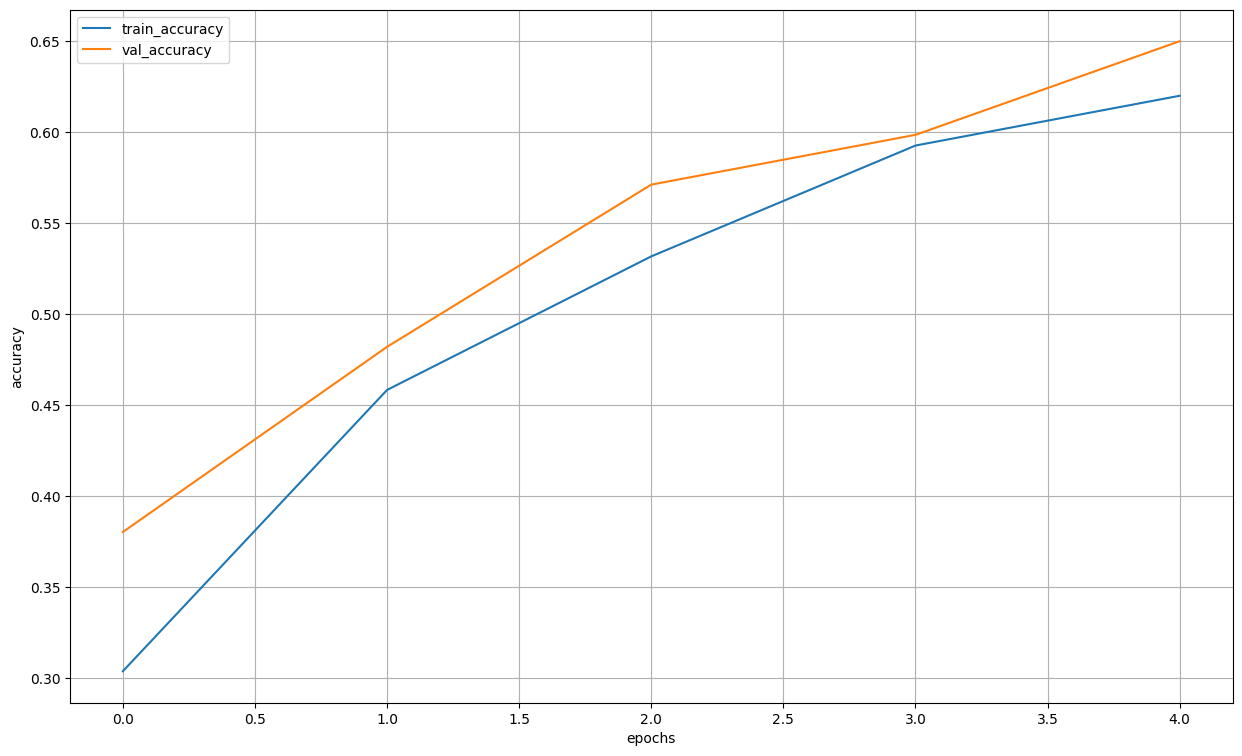

In [ ]:
loss_v3, acc_v3, val_loss_v3, val_acc_v3 = zip(*history_v3)
# val_acc_v3 = [acc.item() for acc in val_acc_v2]

plt.figure(figsize=(15, 9))
plt.plot(acc_v2, label="train_accuracy")
plt.plot(val_acc_v2, label="val_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()
plt.show()